## Creación de un montaje 10x15cm para DNI

Este proyecto genera un montaje de 12 fotos de DNI con recorte perfecto a partir de una imagen sin recortar.

La imagen debe tener fondo blanco, y por supuesto, márgen suficiente para el recorte.

Las imágenes del resultado tendrán brillo variable.

In [15]:
# !pip install ipympl # Descomentar si es necesario
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets

# Activar ipympl para manejo de eventos en Jupyter
%matplotlib widget

## Datos generales

In [16]:
# Parámetros del DNI
altura=32
anchura=26
cara=23.5
margenSup=2

# Tamaño final del resultado
mmX=100
mmY=150

# Número de filas y columnas
filas = 4
columnas = 3

## Calculamos la foto recortada 

Se carga la imagen, y se esperan dos clicks con los que recortamos la foto con las proporciones correctas, y margenes proporcionales a la cara.
* El primer click, en lo alto del pelo, es para dejar 2mm en blanco por arriba (obligatorios)
* El segundo click, en la base de la barbilla, es para que la cara mida 23.5cm (mínimo 20cm, máximo 25cm)

**Nota:** El centro de la foto recortada será el del click de la barbilla

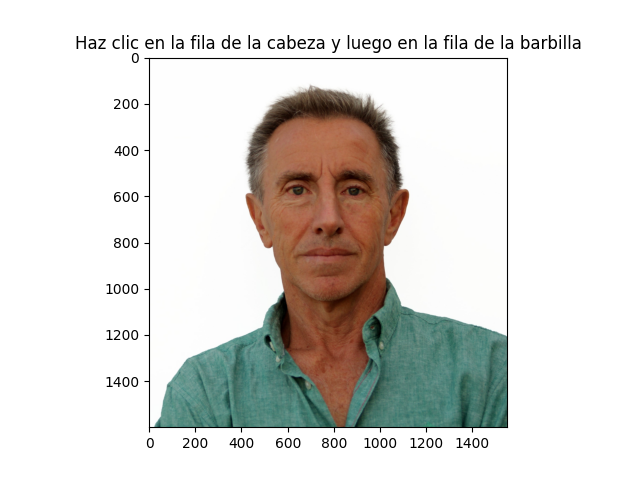

No such comm: f6c6b813fc8744a686247ffaa9d4c5f4
No such comm: f6c6b813fc8744a686247ffaa9d4c5f4


In [18]:


def calcular_coordenadas(cabeza_y, barbilla_y, ancho, alto,centro):
    # Calcula el alto total de la cara con la proporción 32, 
    # dividiéndolo en partes
    abajo=altura-cara-margenSup

    altura_total = barbilla_y - cabeza_y
    altura_imagen = (altura / cara) * altura_total

    # Calcula las coordenadas superiores e inferiores según las proporciones dadas
    y_sup = cabeza_y - int((margenSup / cara) * altura_total)
    y_inf = barbilla_y + int((abajo / cara) * altura_total)

    # Calcula el ancho para respetar la proporción 26/32
    ancho_deseado = int((anchura / altura) * (y_inf - y_sup))
    x_centro = ancho // 2
    x_centro=centro
    x_izq = x_centro - ancho_deseado // 2
    x_der = x_centro + ancho_deseado // 2

    return (x_izq, y_sup, x_der, y_inf)

def on_click(event):
    global puntos, img, fig, ax,img_crop
    # Registra los puntos de clic
    if event.inaxes == ax:
        puntos.append((event.xdata, event.ydata))
        
        # Si ya hay dos puntos, calcula el recorte y muestra la imagen recortada
        if len(puntos) == 2:
            cabeza_y, barbilla_y = int(puntos[0][1]), int(puntos[1][1])
            centro=puntos[1][0] # la barbilla es el centro de la foto
            ancho, alto = img.size
            coords = calcular_coordenadas(cabeza_y, barbilla_y, ancho, alto,centro)
            
            # Recortar la imagen
            img_crop = img.crop(coords)
            img_crop.show()
            img_crop.save('foto_crop.jpg')
            # Cierra la figura después de la selección
            plt.close(fig)

# Cargar imagen
#ruta_imagen = input("Ingresa la ruta de la imagen: ")
ruta_imagen='foto.jpeg'
img = Image.open(ruta_imagen)

# Configura la figura y los clics
puntos = []
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Haz clic en la fila de la cabeza y luego en la fila de la barbilla")

# Conectar el evento de clic a la función
cid = fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()


## Correcciones de brillo
Se generarán 3 columnas y 4 filas de réplicas. 
Cada fila de fotos tiene un brillo diferente. Ajustar al gusto el siguiente array (0%,5%,10%,15%)
La policía elegirá la que mejor considere

In [19]:
from PIL import ImageEnhance

valores=[1,1.05,1.15,1.20]

# Ajustar brillo de la imagen original
enhancer = ImageEnhance.Brightness(img_crop)

# Imagen con un 5% más de brillo
img_brillo_0 = enhancer.enhance(valores[0])
img_brillo_1 = enhancer.enhance(valores[1])
img_brillo_2 = enhancer.enhance(valores[2])
img_brillo_3 = enhancer.enhance(valores[3])


## Preparamos el montaje

Es necesario determinar el espaciado en píxeles a partir del tamaño de la imagen recortada en píxeles.

Para ello hay que extrapolar a milímetros previamente

In [20]:
# Dimensiones individuales de cada imagen basadas en img
ancho_individual, alto_individual = img_crop.size

# ancho y alto sin separaciones
pixelsFotosX=ancho_individual*columnas 
pixelsFotosY =alto_individual*filas

# mm de blancos totales
mmBlancosX=mmX-columnas*anchura
mmBlancosY=mmY-filas*altura

# ratios total/fotos
ratioX=mmX/(mmX-mmBlancosX)
ratioY=mmY/(mmY-mmBlancosY)

# pixeles totales
pixelsX=int(pixelsFotosX*(ratioX))
pixelsY=int(pixelsFotosY*(ratioY))

# comprobamos resultados
print(pixelsY/pixelsX)

espaciadox=int((pixelsX-pixelsFotosX)/(columnas+1))
espaciadoy=int((pixelsX-pixelsFotosX)/(filas+1))



1.5


## Generación de la imagen 

Creamos la imagen final con la matriz de fotos a distintos brillos. Le añadimos un sutil marco de 1 pixel de color gris.

In [29]:
from PIL import Image, ImageDraw

# Crear una superimagen en blanco
superimagen = Image.new("RGB", (pixelsX, pixelsY), "white")

# Lista de imágenes originales que queremos repetir en bloques de tres
imagenes_base = [img_brillo_0, img_brillo_1, img_brillo_2, img_brillo_3]

# Crear lista de imágenes con cada imagen repetida tres veces para llenar la cuadrícula de 3x4
imagenes = [img for img in imagenes_base for _ in range(columnas)]
nimagenes=len(imagenes)
# Colocar cada imagen en la cuadrícula 3x4
for i in range(filas):
    for j in range(columnas):
        # Calcular la posición de la imagen
        x = j * (ancho_individual + espaciadox) + espaciadox
        y = i * (alto_individual + espaciadoy) + espaciadoy
        # Dibujar un marco gris de un píxel alrededor de la imagen
        ImageDraw.Draw(superimagen).rectangle(
            [x - 1, y - 1, x + ancho_individual, y + alto_individual], outline="gray"
        )

        # Insertar la imagen en la superimagen
        superimagen.paste(imagenes[(i * columnas + j)%nimagenes], (x, y))

# Mostrar la superimagen (opcional)
superimagen.show()
superimagen.save('final.jpg')

In [30]:
# Opcionalmente puede escalar la imagen, para facilitar la impresión
dpi=600
resolucion=dpi/25.4 # en puntos por mm
superimagen.resize((int(mmX*resolucion),int(mmY*resolucion))).save('foto600ppp.jpg', dpi=(dpi, dpi))